Images were retrieved from 
https://www.kaggle.com/praveengovi/coronahack-chest-xraydataset

# Torch Setup

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
print("PyTorch Version: ",torch.__version__)

PyTorch Version:  1.5.0


## Data Exploration

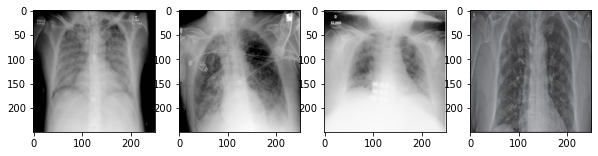

In [3]:


fig, axes = plt.subplots(figsize=(10,4), ncols=4)
imgs_show = torchvision.datasets.ImageFolder(root="../input/lung-infection-scans/Coronahack-Chest-XRay-Dataset/train/",
                                             transform=transforms.Resize((250,250)))
imgs_iter = iter(imgs_show)
for i in range(4):
    ax=axes[i]
    ax.imshow(next(imgs_iter)[0])

In [4]:
import pandas as pd
import numpy as np
meta_data = pd.read_csv('../input/lung-infection-scans/Coronahack-Chest-XRay-Dataset/Chest_xray_Corona_Metadata.csv')

summary_data = pd.read_csv('../input/lung-infection-scans/Coronahack-Chest-XRay-Dataset/Chest_xray_Corona_dataset_Summary.csv')


In [5]:
meta_data.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [6]:
summary_data

,Unnamed: 0,Label,Label_1_Virus_category,Label_2_Virus_category,Image_Count
0,0,Normal,NaN,NaN,1576
1,1,Pnemonia,Stress-Smoking,ARDS,2
2,2,Pnemonia,Virus,NaN,1493
3,3,Pnemonia,Virus,COVID-19,58
4,4,Pnemonia,Virus,SARS,4
5,5,Pnemonia,bacteria,NaN,2772
6,6,Pnemonia,bacteria,Streptococcus,5


In [7]:
meta_data.groupby(by='Label_2_Virus_category').count()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_1_Virus_category
Label_2_Virus_category,,,,,
ARDS,2,2,2,2,2
COVID-19,58,58,58,58,58
SARS,4,4,4,4,4
Streptococcus,5,5,5,5,5


In [8]:
for i in range(len(summary_data)):
    l2 = summary_data.iloc[i,3]
    l1 = summary_data.iloc[i,2]
    if type(l1) != str:
        summary_data.iloc[i,2] = 'Normal'
        summary_data.iloc[i,3] = 'Normal'
    if (type(l1) == str) and (type(l2) != str):
        summary_data.iloc[i,3] = l1
            
summary_data.drop('Unnamed: 0', axis=1, inplace=True)


## Load, Normalize, and Rebalance Data

#### Calculate Mean and Std for normalization

In [9]:
nimages = 0
mean = 0.
std = 0.
trs = transforms.Compose([transforms.Resize((250,250)),transforms.ToTensor()])
imgs = torchvision.datasets.ImageFolder(root="../input/lung-infection-scans/Coronahack-Chest-XRay-Dataset/train/",
                                       transform=trs)
loader = torch.utils.data.DataLoader(imgs, batch_size=16, num_workers=2)


for batch, _ in loader:
    batch = batch.view(batch.size(0), batch.size(1), -1)
    nimages += batch.size(0)
    mean += batch.mean(2).sum(0) 
    std += batch.std(2).sum(0)

# Final step
mean /= nimages
std /= nimages

print(mean)
print(std)

tensor([0.4828, 0.4829, 0.4829])
tensor([0.2215, 0.2215, 0.2215])


#### Rebalanced Sampling

In [10]:
transform = transforms.Compose(
    [transforms.Resize((250,250)),
     transforms.ToTensor(),     
     transforms.Normalize((0.4828, 0.4829, 0.4829), (0.2215, 0.2215, 0.2215))])

trainset = torchvision.datasets.ImageFolder(root="../input/lung-infection-scans/Coronahack-Chest-XRay-Dataset/train/",transform=transform)

testset = torchvision.datasets.ImageFolder(root="../input/lung-infection-scans/Coronahack-Chest-XRay-Dataset/test/",transform=transform)


In [11]:
idx2class = {v: k for k, v in trainset.class_to_idx.items()}
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for element in dataset_obj:
        y_lbl = element[1]
        y_lbl = idx2class[y_lbl]
        count_dict[y_lbl] += 1
            
    return count_dict
print("Distribution of classes: \n", get_class_distribution(trainset))

def get_class_distribution_loaders(dataloader_obj, dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for _,j in dataloader_obj:
        y_idx = j.item()
        y_lbl = idx2class[y_idx]
        count_dict[str(y_lbl)] += 1
            
    return count_dict

target_list = torch.tensor(trainset.targets)
target_list = target_list[torch.randperm(len(target_list))]
class_count = [i for i in get_class_distribution(trainset).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
class_weights

Distribution of classes: 
 {'ARDS': 2, 'COVID-19': 58, 'Normal': 1342, 'SARS': 4, 'Streptococcus': 5, 'Virus': 1345, 'bacteria': 2530}


tensor([5.0000e-01, 1.7241e-02, 7.4516e-04, 2.5000e-01, 2.0000e-01, 7.4349e-04,
        3.9526e-04])

In [12]:
class_weights_all = class_weights[target_list]
class_weights_all

tensor([0.0004, 0.0007, 0.0004,  ..., 0.0004, 0.0004, 0.0007])

In [13]:
from torch.utils.data import WeightedRandomSampler

weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

#### Load data

In [14]:
trainloader = torch.utils.data.DataLoader(trainset, sampler=weighted_sampler, 
                                          batch_size=16,
                                          num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False,
                                         num_workers=2)

## Model Construction

In [15]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 15, 3, 1)
        self.fc1 = nn.Linear(61*61*15, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128,64)
        self.fc4 = nn.Linear(64,8)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2) 
        x = F.relu(self.conv2(x)) 
        x = F.max_pool2d(x, 2, 2) 
        x = x.view(-1, 61*61*15)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [16]:
def train(model, device, train_loader, optimizer, epoch, log_interval=100):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        criterion = nn.CrossEntropyLoss()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(data), len(train_loader.dataset), 
                100. * batch_idx / len(train_loader), loss.item()
            ))

In [17]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            criterion = nn.CrossEntropyLoss()
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return [test_loss, accuracy]

## Training, Testing

#### Looking for optimal learning rate for SGD

In [18]:
torch.manual_seed(619)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
epochs = 10
lrs = [0.00001,0.0001,0.001,0.01]
momentum = 0.5
model = Net().to(device)
test_results_sgd = pd.DataFrame(columns=['Epoch', 'LearningRate', 'Loss', 'Accuracy'])

for lr in lrs:
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    print('-------Learning Rate:  ',lr,'-------')

    for epoch in range(1, epochs + 1):
        train(model, device, trainloader, optimizer, epoch)
        results = test(model, device, testloader)
        loss = results[0]
        acc = results[1]
        t = pd.DataFrame({
            'Epoch':[int(epoch)],
            'LearningRate':[str(lr)],
            'Loss':[loss],
            'Accuracy':[acc]
        })
        test_results_sgd = test_results_sgd.append(t, ignore_index=True)

-------Learning Rate:   1e-05 -------
Train Epoch: 1 [0/5286 (0.000000%)]	Loss: 2.090038
Train Epoch: 1 [1600/5286 (30.211480%)]	Loss: 2.090596
Train Epoch: 1 [3200/5286 (60.422961%)]	Loss: 2.065031
Train Epoch: 1 [4800/5286 (90.634441%)]	Loss: 2.061079

Test set: Average loss: 0.1302, Accuracy: 1/633 (0%)

Train Epoch: 2 [0/5286 (0.000000%)]	Loss: 2.066659
Train Epoch: 2 [1600/5286 (30.211480%)]	Loss: 2.074087
Train Epoch: 2 [3200/5286 (60.422961%)]	Loss: 2.044473
Train Epoch: 2 [4800/5286 (90.634441%)]	Loss: 2.047124

Test set: Average loss: 0.1292, Accuracy: 54/633 (9%)

Train Epoch: 3 [0/5286 (0.000000%)]	Loss: 2.037223
Train Epoch: 3 [1600/5286 (30.211480%)]	Loss: 2.033700
Train Epoch: 3 [3200/5286 (60.422961%)]	Loss: 2.044332
Train Epoch: 3 [4800/5286 (90.634441%)]	Loss: 2.032631

Test set: Average loss: 0.1284, Accuracy: 220/633 (35%)

Train Epoch: 4 [0/5286 (0.000000%)]	Loss: 2.015194
Train Epoch: 4 [1600/5286 (30.211480%)]	Loss: 2.021518
Train Epoch: 4 [3200/5286 (60.422961%)]

#### Looking for optimal learning rate for Adam

In [19]:
torch.manual_seed(619)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
epochs = 10
lrs = [0.00001,0.0001,0.001,0.01]
model = Net().to(device)
test_results_adam = pd.DataFrame(columns=['Epoch', 'LearningRate', 'Loss', 'Accuracy'])

for lr in lrs:
    optimizer = optim.Adam(model.parameters(), lr=lr)
    print('-------Learning Rate:  ',lr,'-------')
    for epoch in range(1, epochs + 1):
        train(model, device, trainloader, optimizer, epoch)
        results = test(model, device, testloader)
        loss = results[0]
        acc = results[1]
        t = pd.DataFrame({
            'Epoch':[int(epoch)],
            'LearningRate':[str(lr)],
            'Loss':[loss],
            'Accuracy':[acc]
        })
        test_results_adam = test_results_adam.append(t, ignore_index=True)


-------Learning Rate:   1e-05 -------
Train Epoch: 1 [0/5286 (0.000000%)]	Loss: 2.090038
Train Epoch: 1 [1600/5286 (30.211480%)]	Loss: 1.292344
Train Epoch: 1 [3200/5286 (60.422961%)]	Loss: 0.812044
Train Epoch: 1 [4800/5286 (90.634441%)]	Loss: 0.803074

Test set: Average loss: 0.0570, Accuracy: 376/633 (59%)

Train Epoch: 2 [0/5286 (0.000000%)]	Loss: 0.350497
Train Epoch: 2 [1600/5286 (30.211480%)]	Loss: 0.475189
Train Epoch: 2 [3200/5286 (60.422961%)]	Loss: 0.251224
Train Epoch: 2 [4800/5286 (90.634441%)]	Loss: 0.325184

Test set: Average loss: 0.0582, Accuracy: 397/633 (63%)

Train Epoch: 3 [0/5286 (0.000000%)]	Loss: 0.400957
Train Epoch: 3 [1600/5286 (30.211480%)]	Loss: 0.479160
Train Epoch: 3 [3200/5286 (60.422961%)]	Loss: 0.222347
Train Epoch: 3 [4800/5286 (90.634441%)]	Loss: 0.435395

Test set: Average loss: 0.0605, Accuracy: 406/633 (64%)

Train Epoch: 4 [0/5286 (0.000000%)]	Loss: 0.259515
Train Epoch: 4 [1600/5286 (30.211480%)]	Loss: 0.066697
Train Epoch: 4 [3200/5286 (60.4229

#### Visuals against learning rate

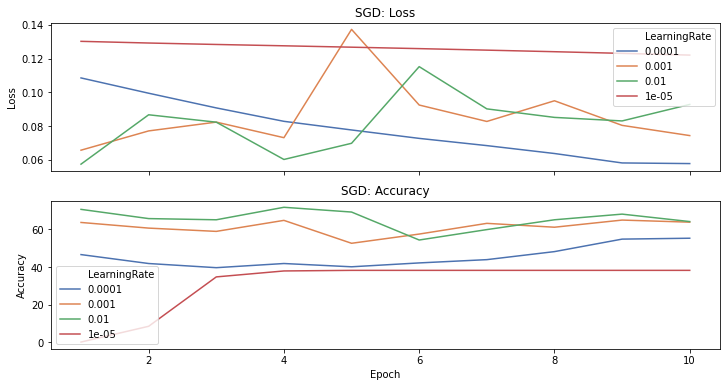

In [20]:
ys = ['Loss', 'Accuracy']
f, axes = plt.subplots(2,1, sharex=True, figsize=(12,6))

for i in range(2):
    ax = axes[i]
    sns.lineplot(x='Epoch', y=ys[i], hue='LearningRate',data=test_results_sgd,
                palette='deep', ax=ax)
    title = 'SGD: ' + ys[i]
    ax.set_title(title)

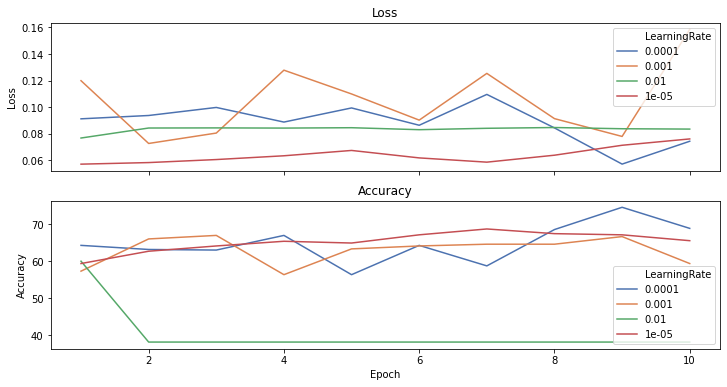

In [21]:
ys = ['Loss', 'Accuracy']
f, axes = plt.subplots(2,1, sharex=True, figsize=(12,6))

for i in range(2):
    ax = axes[i]
    sns.lineplot(x='Epoch', y=ys[i], hue='LearningRate',data=test_results_adam,
                palette='deep', ax=ax)
    title = 'Adam: '+ys[i]
    ax.set_title(ys[i])

#### Training & Testing for both optimizers

In [28]:
torch.manual_seed(619)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

lr = 0.0005
momentum = 0.5
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr)

epochs = 25

results_sgd = [ ]

for epoch in range(1, epochs + 1):
    train(model, device, trainloader, optimizer, epoch)
    results = test(model, device, testloader)
    results_sgd+=list(results)

save_model = False
if (save_model):
    torch.save(model.state_dict(),"covid_cnn.pt")

Train Epoch: 1 [0/5286 (0.000000%)]	Loss: 2.090038
Train Epoch: 1 [1600/5286 (30.211480%)]	Loss: 2.002465
Train Epoch: 1 [3200/5286 (60.422961%)]	Loss: 1.693316
Train Epoch: 1 [4800/5286 (90.634441%)]	Loss: 1.487552

Test set: Average loss: 0.1030, Accuracy: 275/633 (43%)

Train Epoch: 2 [0/5286 (0.000000%)]	Loss: 1.564716
Train Epoch: 2 [1600/5286 (30.211480%)]	Loss: 1.683778
Train Epoch: 2 [3200/5286 (60.422961%)]	Loss: 1.249364
Train Epoch: 2 [4800/5286 (90.634441%)]	Loss: 1.187016

Test set: Average loss: 0.0833, Accuracy: 271/633 (43%)

Train Epoch: 3 [0/5286 (0.000000%)]	Loss: 1.201855
Train Epoch: 3 [1600/5286 (30.211480%)]	Loss: 1.076605
Train Epoch: 3 [3200/5286 (60.422961%)]	Loss: 1.032249
Train Epoch: 3 [4800/5286 (90.634441%)]	Loss: 1.009124

Test set: Average loss: 0.0695, Accuracy: 274/633 (43%)

Train Epoch: 4 [0/5286 (0.000000%)]	Loss: 0.847286
Train Epoch: 4 [1600/5286 (30.211480%)]	Loss: 0.721654
Train Epoch: 4 [3200/5286 (60.422961%)]	Loss: 0.716347
Train Epoch: 4 [4

In [29]:
torch.manual_seed(619)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

lr = 0.00001
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

epochs = 25

results_adam = [ ]

for epoch in range(1, epochs + 1):
    train(model, device, trainloader, optimizer, epoch)
    results = test(model, device, testloader)
    results_adam+=list(results)

save_model = False
if (save_model):
    torch.save(model.state_dict(),"covid_cnn.pt")

Train Epoch: 1 [0/5286 (0.000000%)]	Loss: 2.090038
Train Epoch: 1 [1600/5286 (30.211480%)]	Loss: 1.292357
Train Epoch: 1 [3200/5286 (60.422961%)]	Loss: 0.811971
Train Epoch: 1 [4800/5286 (90.634441%)]	Loss: 0.805547

Test set: Average loss: 0.0571, Accuracy: 375/633 (59%)

Train Epoch: 2 [0/5286 (0.000000%)]	Loss: 0.353972
Train Epoch: 2 [1600/5286 (30.211480%)]	Loss: 0.475929
Train Epoch: 2 [3200/5286 (60.422961%)]	Loss: 0.253683
Train Epoch: 2 [4800/5286 (90.634441%)]	Loss: 0.328355

Test set: Average loss: 0.0582, Accuracy: 395/633 (62%)

Train Epoch: 3 [0/5286 (0.000000%)]	Loss: 0.404758
Train Epoch: 3 [1600/5286 (30.211480%)]	Loss: 0.476888
Train Epoch: 3 [3200/5286 (60.422961%)]	Loss: 0.219085
Train Epoch: 3 [4800/5286 (90.634441%)]	Loss: 0.434425

Test set: Average loss: 0.0608, Accuracy: 404/633 (64%)

Train Epoch: 4 [0/5286 (0.000000%)]	Loss: 0.256240
Train Epoch: 4 [1600/5286 (30.211480%)]	Loss: 0.065955
Train Epoch: 4 [3200/5286 (60.422961%)]	Loss: 0.370459
Train Epoch: 4 [4

In [30]:
res_summary = pd.DataFrame(columns=['Epoch','Optimizer','Loss','Accuracy'])
for i in range(0,50,2):
    loss_sgd = results_sgd[i]
    acc_sgd = results_sgd[i+1]
    loss_adam = results_adam[i]
    acc_adam = results_adam[i+1]
    
    epoch = 1 + i/2
    opts = ['SGD','Adam']
    t = pd.DataFrame({
        'Epoch':[int(epoch),int(epoch)],
        'Optimizer': opts,
        'Loss': [loss_sgd, loss_adam],
        'Accuracy': [acc_sgd, acc_adam]
    })
    res_summary = res_summary.append(t, ignore_index=True)
    

Text(0.5, 1.0, 'Loss vs. Epoch')

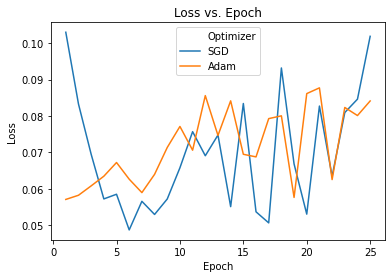

In [31]:
sns.lineplot(x='Epoch',y='Loss',hue='Optimizer',data=res_summary)
plt.title('Loss vs. Epoch')

Text(0.5, 1.0, 'Accuracy vs. Epoch')

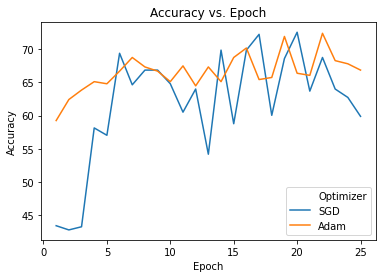

In [32]:
sns.lineplot(x='Epoch',y='Accuracy',hue='Optimizer',data=res_summary)
plt.title('Accuracy vs. Epoch')